#**Predicting Borrower Behavior to Maximize Lifetime Value**
*Why do some lendees take new loans and trade their existing cars, while others don't?*
------
------


>**Overview**: This dataset comes from Chicago Acceptance's transaction history and is comprised of 6,000 vehicle sales between 01/01/20 and the present. 
>
>C.A. generates revenue from customers paying vehicle loans in payments over the course of 3-5 years. When customers pay off the vehicle, they are considered the full legal owner. Of course, this means the business stops generating income from borrowers who reliably made payments. The business would ideally entice these customers to purchase another vehicle, thereby taking a new loan.
>
>While previous customers are easier to interact with due to the existing relationship, it's challenging to entice someone to take on a new loan. To target C.A.'s outreach efforts, my analysis will focus on customers who traded their vehicle and financed a new one to help determine the key factors that influenced their decision. In turn, we will predict current customers who are likely to trade.

>**The Data**: 
>From a list of 400 possible variables, I hand-selected 22 which I have observed to be likely predictive of a customer trading their vehicle. An alternative I could've used in a future assessment would be to import all of the variables and then used a tree-based model to help determine which variables were indeed predictive. The reason I didn't do this is because the numeric data is saved in string format and, because of missing or incorrect data, is difficult to convert to a continuous numeric format.
>
>It's important to note that for those individuals who traded previously, their trade vehicle information is included in the following variables.
>
>*Trade Year, Trade Make, Trade Odometer, Trade Amount, Trade Lien, Trade Lien Held By*
>
>As mentioned, there is quite a bit of missing, incorrect, or mis-formatted data which is the reason for some alterations early in this notebook.
>
>The models are trained on the most recent ~1000 transactions and tested on ~6000.

>**Procedure**: 
>After preprocessing the data thoroughly, I split the data, then I constructed a decision tree to determine which variables best predicted the "trade" outcome. 
>
>Those variables were remaining balance, repair costs, number of payments remaining, the interest rate, the year and odometer of the vehicle, whether or not it was a Toyota (I told you they live forever!), and income.
>
>Using these variables, I constructed a Random Forest, used XGBoost, and did logistic regression. Then, I evaluated each model using F1 score and the area under the curve of the receiver operating characteristic curve.
>
>Finally, since the scores for each model were quite high, I used these models to make predictions on the larger dataset and combined the data into a neat report for my boss, showing which customers were predicted to have high propensity to trade, along with which models came up with that conclusion.

>**Conclusion**: 
>All three main models concluded that a handful of customers had a high propensity to trade. All in all, about 175 customers were identified by at least one model. This accounts for about 3% of existing customers. The next step is to target a promotion which is meant to specifically entice these customers.


------

#1. Import the relevant libraries and data


In [1]:
import pandas as pd
import numpy as np
import sklearn

#viz
import seaborn as sns
import matplotlib.pyplot as plt

#models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#processing, scaling, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn import tree
from sklearn.tree import _tree

#make it pretty
sns.set()

In [2]:
PATH1= '/content/Train_Lending_Data.csv'
df = pd.read_csv(PATH1)

#2. Exploratory Data Analysis

In [3]:
#see the data 
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
StockNbr,202413,201934,202248,202046,202292,202153,202392,202275,202409,202324
Balance Remaining,0.00,0.00,"10,295.99","11,910.73","8,912.82","11,858.48","10,606.51","10,313.95",0.00,0.00
Total Repairs,928.27,881.62,"2,307.45","2,456.19","3,072.35","1,508.69",353.70,"5,512.37","2,285.28","3,393.52"
Nbr Pmts Remaining,0,0,124,115,112,123,126,100,113,0
Interest Rate,24.9,19.9,14.9,24.9,24.9,21.9,14.9,24.9,24.9,19.9
Trade Year,2001.0,NaN,NaN,NaN,NaN,NaN,2011.0,NaN,NaN,NaN
Trade Make,Acura,NaN,NaN,NaN,NaN,NaN,Chevrolet,NaN,NaN,NaN
Trade Odometer,179119,NaN,NaN,NaN,NaN,NaN,141438,NaN,NaN,NaN
Trade Amount,500.00,0.00,0.00,0.00,0.00,0.00,"2,500.00",0.00,0.00,0.00
Trade Lien,0.00,0.00,0.00,0.00,0.00,0.00,"4,331.98",0.00,0.00,0.00


In [4]:
#Lots of object variables that should be numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StockNbr                1367 non-null   object 
 1   Balance Remaining       1367 non-null   object 
 2   Total Repairs           1367 non-null   object 
 3   Nbr Pmts Remaining      1367 non-null   int64  
 4   Interest Rate           1367 non-null   float64
 5   Trade Year              325 non-null    float64
 6   Trade Make              325 non-null    object 
 7   Trade Odometer          296 non-null    object 
 8   Trade Amount            1367 non-null   object 
 9   Trade Lien              1367 non-null   object 
 10  Trade Lien Held By      209 non-null    object 
 11  Year                    1366 non-null   float64
 12  Make                    1366 non-null   object 
 13  Odometer                1364 non-null   object 
 14  Date of Birth           1090 non-null   

In [5]:
#Describing what is already numeric
df.describe()

,Nbr Pmts Remaining,Interest Rate,Trade Year,Year,Days Late,Debt to Income Ratio,Joint Monthly Income,Primary Monthly Income,Nbr of Dependents,Net Income,PrimaryScoreModelA
count,1367.000000,1367.000000,325.000000,1366.000000,1367.000000,1367.000000,1367.000000,1367.000000,622.000000,1367.000000,1367.000000
mean,85.335040,17.325530,2009.492308,2013.110542,0.621800,9.743233,705.163862,2232.190198,0.495177,1073.805413,14.141185
std,56.591111,9.615067,4.260510,3.742666,19.025595,17.747843,1986.370216,2895.208735,1.097124,2023.629702,20.150164
min,0.000000,0.000000,1989.000000,1989.000000,-66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-78.000000
25%,0.000000,14.900000,2007.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,113.000000,21.900000,2010.000000,2014.000000,0.000000,0.000000,0.000000,2400.000000,0.000000,0.000000,0.000000
75%,126.000000,24.900000,2012.000000,2016.000000,0.000000,16.700000,0.000000,3022.000000,0.000000,2000.000000,28.000000
max,315.000000,24.900000,2018.000000,2023.000000,321.000000,219.200000,48000.000000,72000.000000,6.000000,48125.000000,87.000000


In [6]:
#Renaming columns for convenience
dt = df.dtypes
names = dt.index
new_names = ['stock','bal', 'repair', 'npay','pct', 'tr_yr', 'tr_mk', 'tr_odo',\
             'tr_val', 'tr_lien', 'tr_holder', 'yr', 'mk', 'odo','dob', 'mf', 'dayslate',\
             'dti','jointincome', 'income', 'depend','netincome', 'modela']
namesDict = dict(zip(names,new_names))
df = df.rename(columns=namesDict)

In [7]:
#Showing missing counts by variable
df.isna().sum()
#We know wholesale doesn't have a DOB of gender. We also know n/a dependents means 0.

stock             0
bal               0
repair            0
npay              0
pct               0
tr_yr          1042
tr_mk          1042
tr_odo         1071
tr_val            0
tr_lien           0
tr_holder      1158
yr                1
mk                1
odo               3
dob             277
mf              574
dayslate          0
dti               0
jointincome       0
income            0
depend          745
netincome         0
modela            0
dtype: int64

In [8]:
# Quick check for duplicates
duplicateRows = df[df.duplicated()]
duplicateRows

,stock,bal,repair,npay,pct,tr_yr,tr_mk,tr_odo,tr_val,tr_lien,...,odo,dob,mf,dayslate,dti,jointincome,income,depend,netincome,modela


#3. Data Preprocessing
Changing the types to numeric where needed, imputing missing data, and dropping irrelevant data

In [9]:
len1 = len(df)

In [10]:
#drop the rows where interest % is 0
#these are wholesale deals

before = len(df)

df.drop(df[df['pct'] == 0].index, inplace=True)

after = len(df)

print(f'{before-after} dropped')

295 dropped


In [11]:
#Change these numeric variables from string to floats
df[['bal','repair','tr_val','tr_lien']] = df[['bal','repair','tr_val','tr_lien']].replace(',','',regex=True)
df[['bal','repair','tr_val','tr_lien']] = df[['bal','repair','tr_val','tr_lien']].astype('float64')

In [12]:
#Drop all cash deals, since they did not take a loan
before = len(df)

df.drop(df[df['bal'] == 0].index, inplace = True)

after = len(df)

print(f'{before-after} cash deals dropped')

132 cash deals dropped


In [13]:
#Since negative repair value is a typo and means the same as positive, let's change everything to be positive
df['repair']=df['repair'].abs()

Rather than imputing DOB with the median, which may be a sub-par strategy, I may want to use a decision tree to impute this data in the future.

In [14]:
#change dob variable to datetime and select just the year
df['dob'] = pd.to_datetime(df['dob'])
df['dob'] = df['dob'].dt.year

#impute missing dobs as the median dob
df['dob'].fillna(df['dob'].median(),inplace = True)

In [15]:
#Correcting spelling mistakes in Lien Holder values, then simplifying
newHolder = []

for i in df.tr_holder:
  if i in ['Paid off', 'Paid off!!','paid off']:
    newHolder.append('paid')
  elif i in ['Chicagp Acceptance','CHICAGO ACCEPTANCE','CHICAGO ACCEPTANCE LLC',\
             'Chicago Acceptance', 'CHICGAO ACCEPTANCE', 'Chicago acceptance', \
             'CHICAGO Acceptance llc', 'CHIGCAO ACCEPTANCE', 'Chicago Aceptance']:
    newHolder.append('CA')
  elif i == 'Wheels of Chicago':
    newHolder.append('WOC')
  else:
    newHolder.append(i)

df['tr_holder'] = newHolder


In [16]:
#Since n/a dependents means zero dependents, we impute
df['depend'].fillna(0,inplace = True)

In [17]:
#make odo a float
df['odo'] = df['odo'].astype('float64')
df['odo'].fillna(df['odo'].median(),inplace = True)

A better strategy in the future may be to add a flag variable for any trade odometer which I impute. Hopefully this could help compensate for any incorrect training when imputing with a manually entered value such as 150,000.

In [18]:
#Vehicles over 10 years old are exempt from government reporting. By the manager's account, the average traded vehicle which is Exempt has around 150,000 miles
#make tr_odo a float
df['tr_odo'] = df['tr_odo'].replace('EXEMPT','150000.0')
df['tr_odo'] = df['tr_odo'].astype('float64')
df['tr_odo'].fillna(df['tr_odo'].median(),inplace = True)

In [19]:
#drop stock
df.drop('stock', axis = 1, inplace = True)

In [20]:
#drop modela column as we see it is non-normal in later visualization
df.drop('modela', axis = 1, inplace = True)

In [21]:
#Check how many values deleted in this section
len2 = len(df)

print(f'Deleted in this section: \n{round(100*(len1 - len2)/len1,1)}\
% of the values ({(len1 - len2)} values) were wholesale and cash deals.')

Deleted in this section: 
31.2% of the values (427 values) were wholesale and cash deals.


#4. Creating Target Variables

In [22]:
#create flag target 
new_names.append('t1')

#set target variable 
df['t1'] = np.where(df['tr_holder'].isna(),0,1)

In [23]:
#Here we are "bringing trades back to the moment they were traded" by saying their trade vehicle is their "current vehicle" and their lien amount is their "balance".

#replace balance with lien value for cars that were traded
df.loc[df['tr_holder'].notna(), 'bal'] = df.loc[df['tr_lien'].notna(), 'tr_lien']

#replace year with trade year for cars that were traded
df.loc[df['tr_holder'].notna(), 'yr'] = df.loc[df['tr_yr'].notna(), 'tr_yr']

#replace make with trade make for cars that were traded
df.loc[df['tr_holder'].notna(), 'mk'] = df.loc[df['tr_mk'].notna(), 'tr_mk']

#replace odo with trade odo for cars that were traded
df.loc[df['tr_holder'].notna(), 'odo'] = df.loc[df['tr_odo'].notna(), 'tr_odo']

#WE CAN CREATE TWO CUSTOMERS FROM ONE IF DESIRED

In [24]:
#drop trade columns
df.drop(['tr_yr','tr_mk','tr_odo','tr_val','tr_lien','tr_holder'], axis = 1, inplace = True)

#5. Data Visualization

In [25]:
#Segment the data into types
dt = df.dtypes

objList = []
intList = []
floatList = []
numericList = []

for i in dt.index:
  if i == 't1':
    continue  
  elif dt[i] in ['object']:
    objList.append(i)  
  elif dt[i] in ['float64']:
    floatList.append(i)  
    numericList.append(i)
  elif dt[i] in ['int64']:
    intList.append(i)
    numericList.append(i)

Name of variable: mk
  -----------
  Total members in each class:

Chevrolet     166
Ford          158
Nissan        153
Kia            68
Jeep           63
Dodge          61
Chrysler       49
Hyundai        47
Honda          27
GMC            22
Toyota         22
Mitsubishi     22
Buick          17
Volkswagen     10
Lincoln         8
Ram             8
Lexus           7
Acura           6
Cadillac        6
MAZDA           5
INFINITI        4
HUMMER          3
Saturn          2
Scion           2
Mercury         1
Audi            1
Pontiac         1
BMW             1
Name: mk, dtype: int64
  ---------



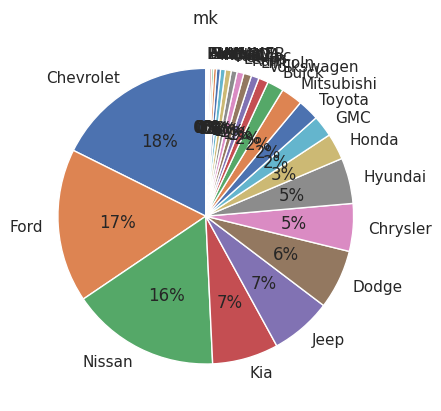

Name of variable: mf
  -----------
  Total members in each class:

M    356
F    301
Name: mf, dtype: int64
  ---------



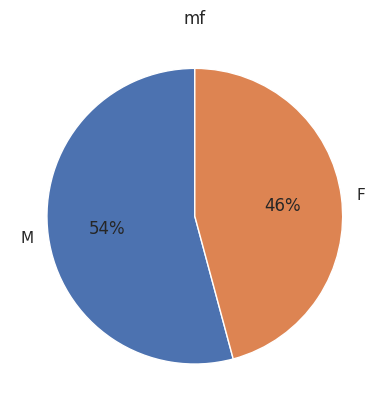

In [26]:
#Note: dropna is set to true
for i in objList:
  x = df[i].value_counts(dropna = True)
  print(f'Name of variable: {i}\n\
  -----------\n\
  Total members in each class:\n\n{x}\n\
  ---------\n')
  # y = df.groupby(i)[i].count()
  # print(y)
  theLabels = x.axes[0].tolist()
  theSlices = list(x)
  plt.pie(theSlices, labels = theLabels, startangle = 90, autopct = '%1.0f%%')
  plt.title(i)
  plt.show() 

A few notes about the below histograms:

1. balance has some high outliers

2. repair costs is skewed right

3. number of payments is normal but may contain different time periods such as weekly or biweekly. Handful of outliers

4. interest percentage is not normal (decided by the GM)

5. yr is normal with an outlier

6. odo is normal

7. dob is skewed left 

8. lots of people have 0 days late and many pay early

9. debt to income ratio has outliers and is skewed right

10. joint income to income ratio has outliers and is skewed right

11. income has outliers

12. dependents is normal except for a high proportion of 0s

13. net income has outliers and is skewed right

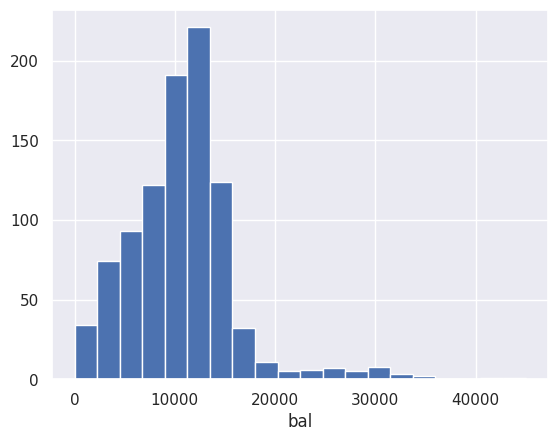

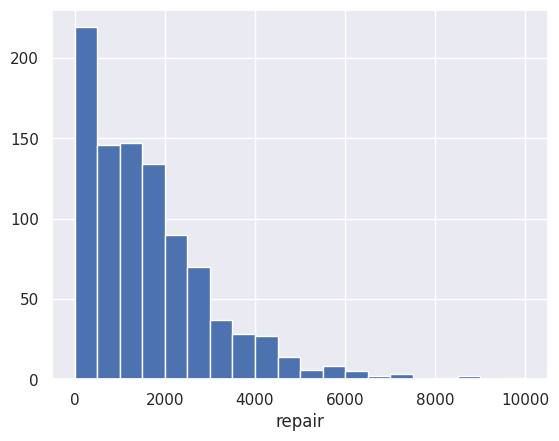

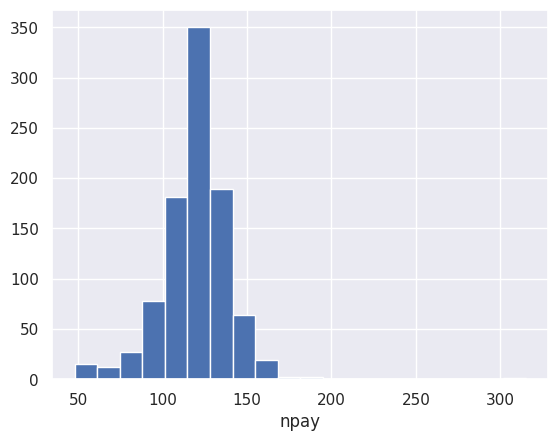

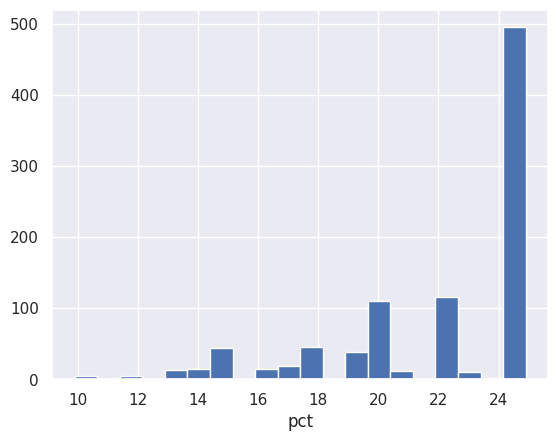

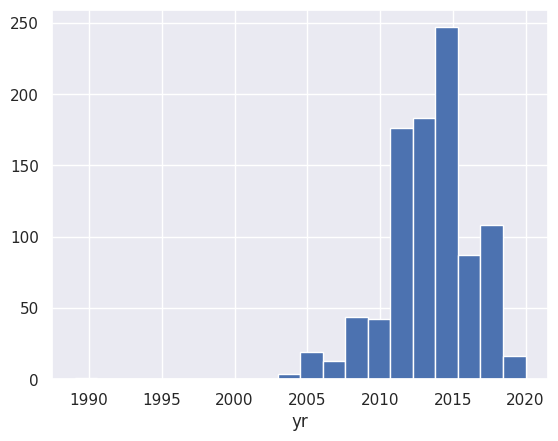

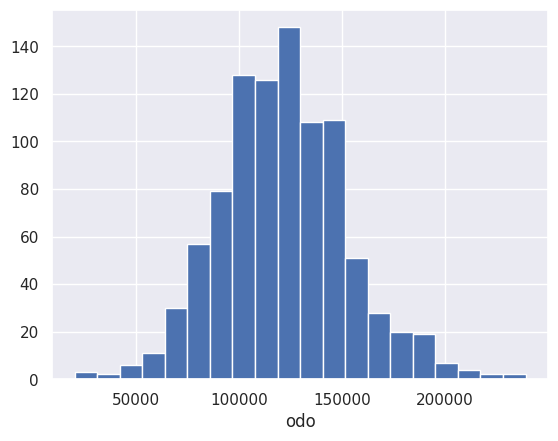

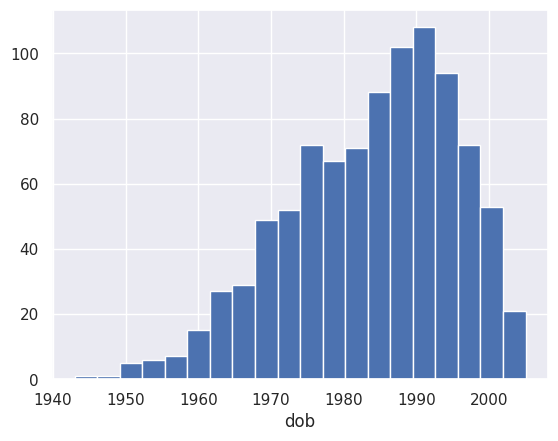

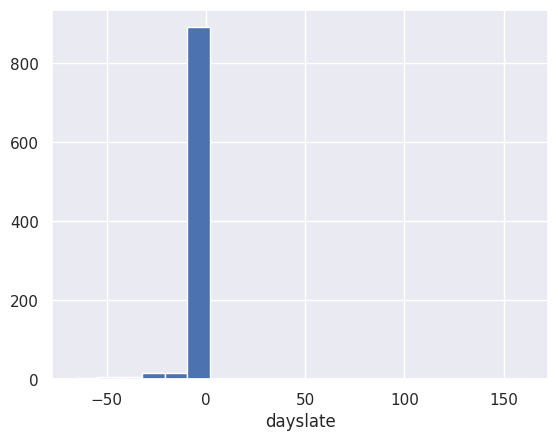

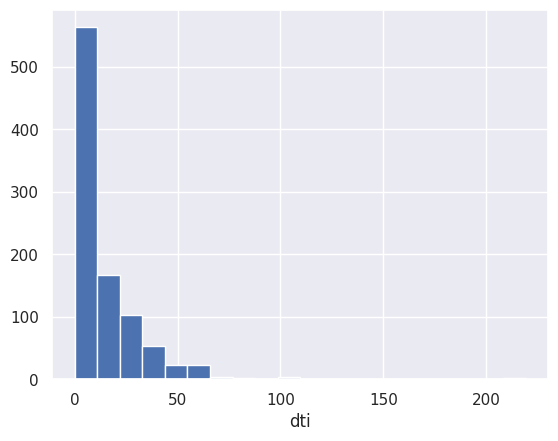

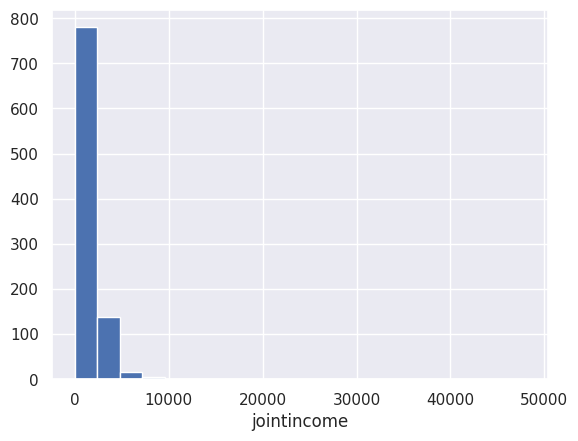

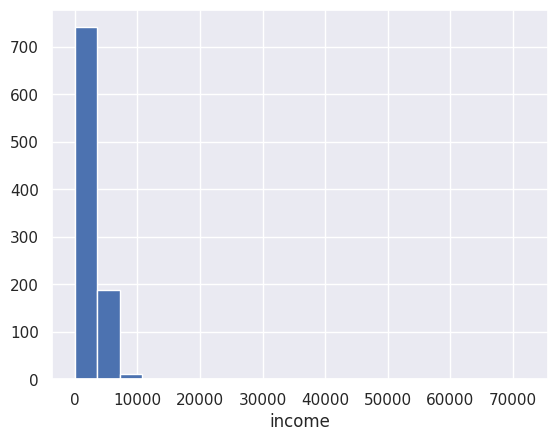

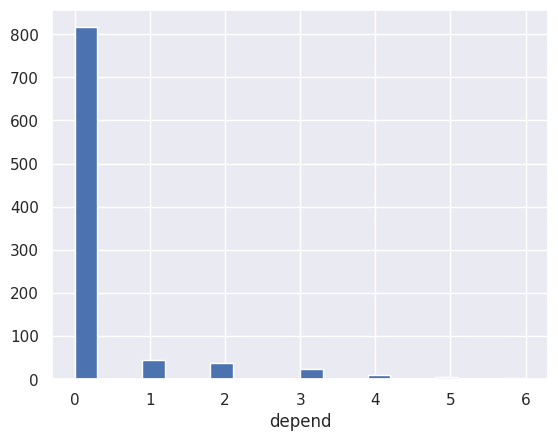

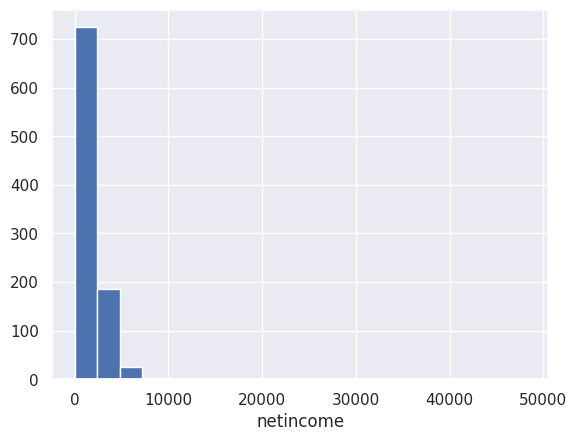

In [27]:
for i in numericList:
  plt.hist(df[i], bins = 20)
  plt.xlabel(i)
  plt.show()

In [28]:
print(f'{round(100*len(df[df.t1==1])/len(df),1)}% of our values are targets')

19.6% of our values are targets


#6. Removing Outliers
Here we are conservative in that we identify outliers as values 5 standard deviations away from the mean, which I know is relatively large.

In [29]:
#identify outliers
outliers = {} 
sum_out = 0
z_val = 5

for i in numericList:
  mean = df[i].mean()
  sd = df[i].std()
  min = mean - z_val*sd
  max = mean + z_val*sd

  outlier_mask = (df[i] < min) | (df[i] > max)
  num_outliers = outlier_mask.sum()
  sum_out += outlier_mask.sum()
  outlier_rows = df.loc[outlier_mask].index.tolist() # get the row numbers of the outliers
  outliers[i] = {"values": df.loc[outlier_mask, i].tolist(), "rows": outlier_rows} # store the values and the row numbers in a dictionary
  
  print(f"{num_outliers} outliers found in column {i}: {outliers[i]}")

print(f'\n\n{sum_out} outliers detected')

2 outliers found in column bal: {'values': [44978.25, 40481.31], 'rows': [1000, 1018]}
2 outliers found in column repair: {'values': [8971.7, 10002.97], 'rows': [50, 930]}
1 outliers found in column npay: {'values': [315], 'rows': [1345]}
0 outliers found in column pct: {'values': [], 'rows': []}
1 outliers found in column yr: {'values': [1989.0], 'rows': [831]}
0 outliers found in column odo: {'values': [], 'rows': []}
0 outliers found in column dob: {'values': [], 'rows': []}
8 outliers found in column dayslate: {'values': [145, -58, -52, -52, -59, -58, -66, 161], 'rows': [625, 990, 999, 1008, 1016, 1017, 1018, 1060]}
3 outliers found in column dti: {'values': [215.0, 219.2, 134.8], 'rows': [630, 933, 1035]}
2 outliers found in column jointincome: {'values': [28880, 48000], 'rows': [444, 812]}
2 outliers found in column income: {'values': [50000, 72000], 'rows': [121, 668]}
8 outliers found in column depend: {'values': [5.0, 6.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0], 'rows': [78, 186, 308, 

In [30]:
#list of rows with outliers

outlier_rows = []

for i in outliers:  
  outlier_rows.append(str(outliers[i]['rows']).replace('[','').replace(']','').split(','))


outlier_list = [int(x.strip()) for sublist in outlier_rows for x in sublist if x.strip()]

In [31]:
#drop outliers

before1 = len(df)

df.drop(outlier_list, axis = 0, inplace = True)

after1 = len(df)

print(f'Including those double-counted, there were {before1-after1} outliers deleted')

Including those double-counted, there were 29 outliers deleted


#7. Quick review of the data

In [32]:
#Looks like gender (mf) and odometer (odo) still contain some n/a values
print(f'Percent n/a in each variable:\n\n\
{100*df.isna().sum()/len(df)}')

Percent n/a in each variable:

bal             0.000000
repair          0.000000
npay            0.000000
pct             0.000000
yr              0.000000
mk              0.000000
odo             0.000000
dob             0.000000
mf             30.186608
dayslate        0.000000
dti             0.000000
jointincome     0.000000
income          0.000000
depend          0.000000
netincome       0.000000
t1              0.000000
dtype: float64


In [33]:
#seems like make might be predictive (or there may not be enough data) 
#gender may not be very predictive

for i in objList:
  print(df[i].unique())
  g1 = df.groupby(i)['t1'].mean().sort_values(ascending = False)
  print(g1)
  print('\n')

['Jeep' 'Buick' 'Chevrolet' 'Mitsubishi' 'Chrysler' 'Ford' 'Nissan'
 'MAZDA' 'Lincoln' 'Volkswagen' 'Dodge' 'Honda' 'Hyundai' 'Acura' 'Kia'
 'Toyota' 'INFINITI' 'Ram' 'Mercury' 'HUMMER' 'GMC' 'Lexus' 'Saturn'
 'Scion' 'Cadillac' 'Audi' 'Pontiac' 'BMW']
mk
Saturn        1.000000
Pontiac       1.000000
Mercury       1.000000
Acura         0.666667
Lexus         0.500000
Scion         0.500000
Cadillac      0.500000
GMC           0.388889
Buick         0.333333
HUMMER        0.333333
Mitsubishi    0.318182
Dodge         0.305085
Chevrolet     0.240506
Honda         0.230769
Volkswagen    0.222222
Ford          0.193548
Toyota        0.181818
Hyundai       0.173913
Nissan        0.145695
Lincoln       0.125000
Ram           0.125000
Chrysler      0.081633
Jeep          0.066667
Kia           0.059701
Audi          0.000000
MAZDA         0.000000
INFINITI      0.000000
BMW           0.000000
Name: t1, dtype: float64


['M' 'F' nan]
mf
F    0.176271
M    0.161290
Name: t1, dtype: float64




In [34]:
#Because it has 30% n/a and doesn't seem predictive, we will drop this column as much as I would've liked to keep it
df.drop('mf', axis = 1, inplace=True)
objList.remove('mf')

#8. One Hot Encoding Categorical Variables

In [35]:
#Add dummy variables for all object type variables (just make now)
for i in objList:
  df[i] = df[i].str.lower()

dummies = pd.get_dummies(df[objList])

df.drop(columns = objList, inplace = True)

df = df.join(dummies)

#9. Normalize the variables
In order to to remove issues arising from different varibales describing quantities of different scales

In [36]:
scaler = MinMaxScaler()

cols = []
for i in df:
  if i != 't1':
    cols.append(i)

df[cols] = scaler.fit_transform(df[cols])

In [37]:
# #If i separate t1, I could also scale more simply in this way
# df = (df-df.mean())/df.std()

#10. Test Correlations
How is the target variable related to the predictors?

In [38]:
corr = df.corr().abs()
corr_sorted_t1=corr[['t1']].abs().sort_values(by = 't1', ascending = False)

print(corr_sorted_t1)

# # heatmap too complicated, therefore it's commented out
# print(sns.heatmap(corr))

                     t1
t1             1.000000
pct            0.574762
bal            0.551111
odo            0.400534
yr             0.393459
npay           0.291418
dti            0.253033
netincome      0.202333
dob            0.153129
mk_acura       0.097212
mk_kia         0.095844
mk_saturn      0.095520
mk_jeep        0.085651
income         0.077961
mk_dodge       0.073689
repair         0.072908
mk_gmc         0.069828
mk_chrysler    0.067888
mk_pontiac     0.067506
mk_mercury     0.067506
mk_cadillac    0.062913
mk_lexus       0.062913
mk_nissan      0.054748
mk_chevrolet   0.053505
mk_mitsubishi  0.049258
mk_buick       0.045469
dayslate       0.042957
mk_mazda       0.036480
mk_scion       0.036243
mk_infiniti    0.032611
mk_hummer      0.020200
mk_lincoln     0.016484
mk_ram         0.016484
mk_bmw         0.016279
mk_audi        0.016279
mk_honda       0.015802
depend         0.012280
mk_hyundai     0.011878
mk_volkswagen  0.007051
mk_toyota      0.004960
mk_ford        0

In [39]:
#Test for multicollinearity 
corr_max = 0.7

high_corr_values = corr[corr > corr_max]
high_corr_combinations = high_corr_values.stack().index.tolist()

for i in high_corr_combinations:
  if i[0] != i[1]:
    print(i)

#No multicollinearity found; if found I would've used PCA to combine the features

#11. Split Dataset
Into test and training data, where test data is 20% of the total

In [40]:
#Define X and y
target = df.t1
variables = df.drop('t1', axis = 1)

#Split the data
X_train, X_test, y_train, y_test = train_test_split(variables, target, test_size=0.2, random_state=42)

In [41]:
#set for later
original = X_train.dtypes.index

#12. Decision Tree Classifier
Since we will likely make a random forest, the main goal here is to see if the decision tree thinks that all the variables are predictive or if only a subset are

In [42]:
#fit
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

#predict
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

In [43]:
#scoring
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
y_proba = dt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print("Decision tree train accuracy:", accuracy_train, "\nDecision tree test accuracy:", accuracy_test )
print("Decision tree F1-score:", f1)

Decision tree train accuracy: 1.0 
Decision tree test accuracy: 0.9562841530054644
Decision tree F1-score: 0.8974358974358975


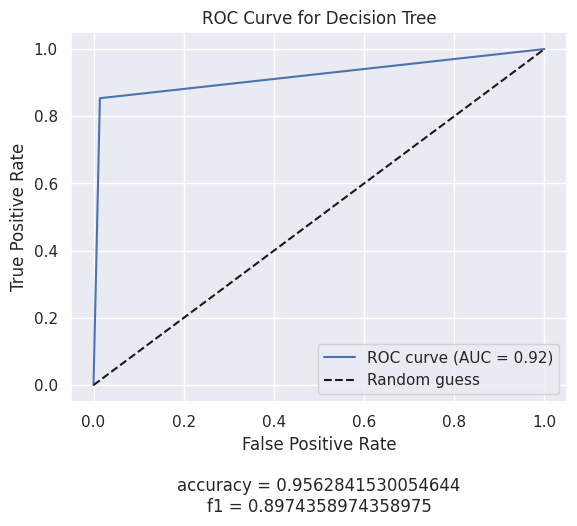

In [44]:
# ROC AUC
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel(f'False Positive Rate\n\naccuracy = {accuracy_test}\nf1 = {f1}')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

In [45]:
#Export graphviz tree, pasted below
feature_cols = list(X_train.columns.values)
tree.export_graphviz(dt, out_file = 'tree_file.txt', feature_names = feature_cols, class_names = ['0','1'], filled = True, rounded = True, impurity = False)

graphviz (1).svg

In [46]:
#Decision Tree selecting some variables 
def getTreeVars( TREE, varNames ) :
  tree_ = TREE.tree_
  varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

  nameSet = set()
  for i in tree_.feature :
    if i != _tree.TREE_UNDEFINED :
      nameSet.add( i )
  nameList = list( nameSet )
  parameter_list = list()
  for i in nameList :
    parameter_list.append( varNames[i] )
  return parameter_list

vars_selected = getTreeVars(dt, feature_cols)
print(f'Decision Tree Selected These Variables:')
for i in vars_selected:
  print(i)

Decision Tree Selected These Variables:
bal
repair
npay
pct
yr
odo
mk_toyota
jointincome
netincome


In the end, the decision tree put emphasis on the above variables, so for the future analysis, we will simplify the dataset to only these. This will help with interpretability and communicating results to my boss, as long as it doesn't impact the performance of the models. By running it both ways, I noticed that using only these columns did not impact performance, implying the other variables are not very predictive.

In [47]:
X_train = X_train[vars_selected]
X_test = X_test[vars_selected]

#13. Random Forest

In [48]:
#fit
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#predict
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

In [49]:
#scoring
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
y_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print("Random Forest train accuracy:", accuracy_train, "\nRandom Forest test accuracy:", accuracy_test )
print("Random Forest F1-score:", f1)

Random Forest train accuracy: 1.0 
Random Forest test accuracy: 0.9672131147540983
Random Forest F1-score: 0.9210526315789475


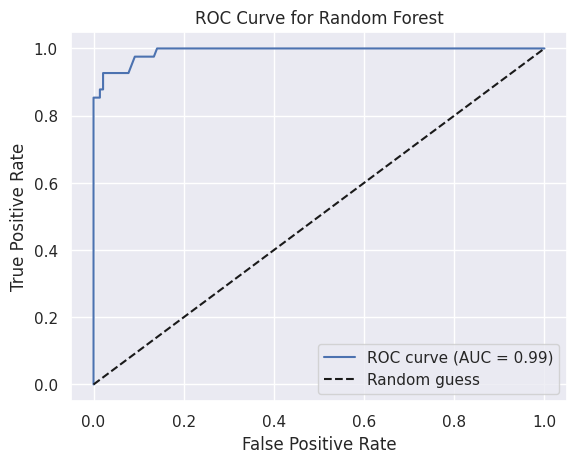

In [50]:
# ROC AUC
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel(f'False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

#14. XGBoost

In [51]:
#fit 
xgb = XGBClassifier(n_estimators=300, random_state=42)
xgb.fit(X_train, y_train)

#predict
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

In [52]:
#scoring
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
y_proba = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
print("Random Forest train accuracy:", accuracy_train, "\nRandom Forest test accuracy:", accuracy_test )
print("Random Forest F1-score:", f1)

Random Forest train accuracy: 1.0 
Random Forest test accuracy: 0.9672131147540983
Random Forest F1-score: 0.9210526315789475


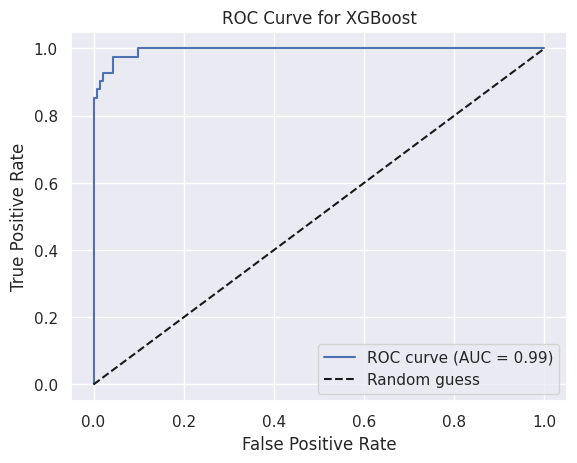

In [53]:
# ROC AUC
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel(f'False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

In [54]:
#let's see how each variable impacted these metrics
for i in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:
  print(f'------------------------\n\n{i}')
  my_dict = xgb.get_booster().get_score(importance_type= i)
  for key, value in my_dict.items():
    print(key + ': ' + str(value))


------------------------

weight
bal: 120.0
repair: 80.0
npay: 96.0
pct: 99.0
yr: 23.0
odo: 156.0
mk_toyota: 1.0
jointincome: 14.0
netincome: 121.0
------------------------

gain
bal: 6.074734210968018
repair: 0.2204272449016571
npay: 2.683764696121216
pct: 1.0379568338394165
yr: 0.9618400931358337
odo: 0.3363502621650696
mk_toyota: 0.2099609375
jointincome: 0.08271320164203644
netincome: 0.14437925815582275
------------------------

cover
bal: 17.66450309753418
repair: 3.744176149368286
npay: 13.722681999206543
pct: 10.146407127380371
yr: 4.5346879959106445
odo: 3.99825119972229
mk_toyota: 61.80515670776367
jointincome: 3.855943202972412
netincome: 4.356769561767578
------------------------

total_gain
bal: 728.9680786132812
repair: 17.634180068969727
npay: 257.64141845703125
pct: 102.75772857666016
yr: 22.12232208251953
odo: 52.47064208984375
mk_toyota: 0.2099609375
jointincome: 1.1579848527908325
netincome: 17.469890594482422
------------------------

total_cover
bal: 2119.740478515

#15. Logistic Regression 
This is binary classification, so log regression especially makes sense to try

In [55]:
#fit
lr = LogisticRegression(penalty='l2', max_iter = 10000, random_state=42)
lr.fit(X_train, y_train)

#predict
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

In [56]:
#scoring
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

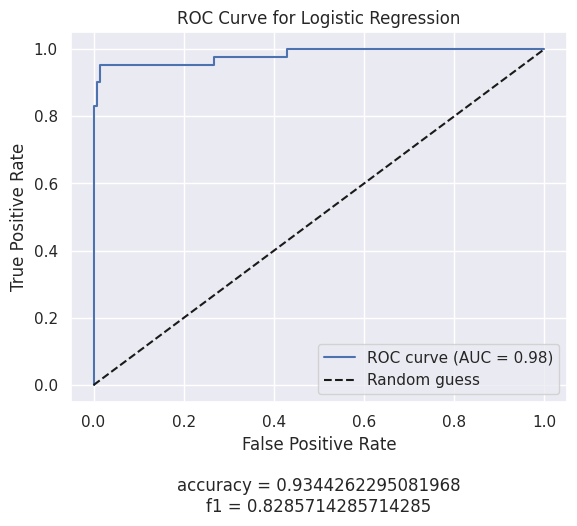

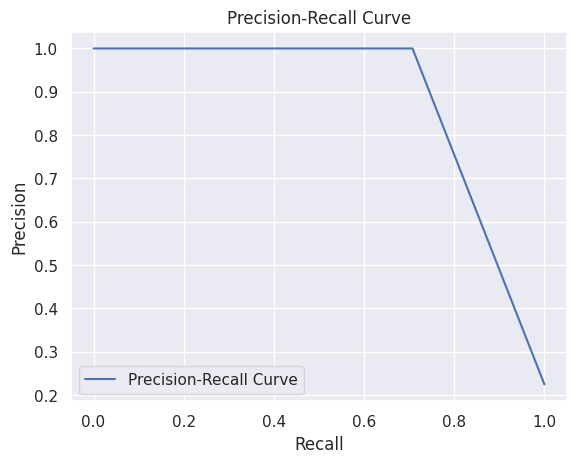

In [57]:
#ROC AUC
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel(f'False Positive Rate\n\naccuracy = {accuracy}\nf1 = {f1}')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

#precision-recall curve
plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [58]:
#See the coefficient weights
lrlist = str(lr.coef_.tolist()).replace('[','').replace(']','').split(',')
lr_coefs = pd.DataFrame([X_train.dtypes.index, lrlist]).T
lr_coefs.columns = ['Variable', 'Weight']
lr_coefs

,Variable,Weight
0,bal,-5.760214862207731
1,repair,-0.5676846730312739
2,npay,2.832227868833471
3,pct,-4.206945217183716
4,yr,-3.000974285995706
5,odo,3.218841446741373
6,mk_toyota,-0.04912544731059568
7,jointincome,-0.1797131730546709
8,netincome,0.8531309099455663


An idea for further analysis: we could try segmenting the balance into buckets (make it an object variable) to see which bucket is most predictive. Although, continuous data seems more precise for this task. Another idea would be to train on this data and then test on data from another year altogether, rather than doing train test split. Although, doing so may introduce conflating factors as predictive features could change between years.

#16. Setting Up New Data
In this section, I'm preprocessing the data to be in the same format as the training data which I built the models on.

In [59]:
#import dataset
PATH2 = '/content/Test_Lending_Data.csv'
df2 = pd.read_csv(PATH2)

In [60]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5845 entries, 0 to 5844
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StockNbr                5845 non-null   object 
 1   Balance Remaining       5845 non-null   object 
 2   Total Repairs           5845 non-null   object 
 3   Nbr Pmts Remaining      5845 non-null   int64  
 4   Interest Rate           5845 non-null   float64
 5   Trade Year              1485 non-null   float64
 6   Trade Make              1485 non-null   object 
 7   Trade Odometer          1396 non-null   object 
 8   Trade Amount            5845 non-null   object 
 9   Trade Lien              5845 non-null   object 
 10  Trade Lien Held By      753 non-null    object 
 11  Year                    5843 non-null   float64
 12  Make                    5843 non-null   object 
 13  Odometer                5801 non-null   object 
 14  Date of Birth           4565 non-null   

In [61]:
dt2 = df2.dtypes
names = dt2.index
new_names = ['stock','bal', 'repair', 'npay','pct', 'tr_yr', 'tr_mk', 'tr_odo',\
             'tr_val', 'tr_lien', 'tr_holder', 'yr', 'mk', 'odo','dob', 'mf', 'dayslate',\
             'dti','jointincome', 'income', 'depend','netincome', 'modela']
namesDict = dict(zip(names,new_names))
df2 = df2.rename(columns=namesDict)

In [62]:
#drop the rows where interest % is 0
#these are wholesale deals

before = len(df2)

df2.drop(df2[df2['pct'] == 0].index, inplace=True)

after = len(df2)

print(f'{before-after} wholesale deals dropped')

1364 wholesale deals dropped


In [63]:
#Change numeric variables to floats
df2[['bal','repair','tr_val','tr_lien']] = df2[['bal','repair','tr_val','tr_lien']].replace(',','',regex=True)
df2[['bal','repair','tr_val','tr_lien']] = df2[['bal','repair','tr_val','tr_lien']].astype('float64')

In [64]:
#Drop all cash deals
before = len(df2)

df2.drop(df2[df2['bal'] == 0].index, inplace = True)

after = len(df2)

print(f'{before-after} cash deals dropped')

620 cash deals dropped


In [65]:
#change repairs to all positive
df2['repair']=df2['repair'].abs()

In [66]:
#make dob just year
df2['dob'] = pd.to_datetime(df2['dob'])
df2['dob'] = df2['dob'].dt.year

#impute missing dobs as the average dob
df2['dob'].fillna(df2['dob'].median(),inplace = True)

In [67]:
#correct holder values
newHolder = []

for i in df2.tr_holder:
  if i in ['Paid off', 'Paid off!!','paid off']:
    newHolder.append('paid')
  elif i in ['Chicagp Acceptance','CHICAGO ACCEPTANCE','CHICAGO ACCEPTANCE LLC',\
             'Chicago Acceptance', 'CHICGAO ACCEPTANCE', 'Chicago acceptance', \
             'CHICAGO Acceptance llc', 'CHIGCAO ACCEPTANCE', 'Chicago Aceptance']:
    newHolder.append('CA')
  elif i == 'Wheels of Chicago':
    newHolder.append('WOC')
  else:
    newHolder.append(i)

df2['tr_holder'] = newHolder

In [68]:
#n/a dependents are interpreted as zero
df2['depend'].fillna(0,inplace = True)

In [69]:
#make odo a str
df2['odo'] = df2['odo'].astype('str')

df2['odo'] = df2['odo'].str.lower()
df2['odo'] = df2['odo'].replace('/','').replace('.','')
df2['odo'] = df2['odo'].\
replace('exempt','150000').replace('exempy','150000').replace('unknwon','150000').replace('nr','150000')

#make odo a float
df2['odo'] = df2['odo'].astype('float64')

#May want to use decision tree instead next time
df2['odo'].fillna(df2['odo'].median(),inplace = True)

In [70]:
#make tr_odo a float
df2['tr_odo'] = df2['tr_odo'].replace('EXEMPT','0.0')
df2['tr_odo'] = df2['tr_odo'].astype('float64')

#May want to use decision tree instead next time
df2['tr_odo'].fillna(df2['tr_odo'].median(),inplace = True)

In [71]:
#drop modela and mf columns
df2.drop(['mf','modela'], axis = 1, inplace = True)

In [72]:
#Add dummy variables for all object type variables
for i in objList:
  df2[i] = df2[i].str.lower()

dummies = pd.get_dummies(df2[objList])

df2.drop(columns = objList, inplace = True)

df2 = df2.join(dummies)

In [73]:
#drop trade columns
df2.drop(['tr_yr','tr_mk','tr_odo','tr_val','tr_lien','tr_holder'], axis = 1, inplace = True)

In [74]:
before = len(df2)

#because new makes are in this data, there are extra dummy variables. We need to remove the rows and columns containing these data
extra_vars = []
for i in list(df2.dtypes.index):
  if i not in list(original):
    if i != 'stock':
      extra_vars.append(i)

#mask to identify rows where columns have a value of 1
mask = (df2[extra_vars] == 1).any(axis=1)

#drop the rows where the mask is True
df2 = df2.loc[~mask]

#drop extra_vars columns
df2.drop(extra_vars, axis=1, inplace=True)

after = len(df2)

print(f'Removed {before-after} rows with variables unseen in training')

Removed 18 rows with variables unseen in training


In [75]:
#drop stock
stock = df2['stock']
df2.drop('stock', axis = 1, inplace = True)

In [76]:
#normalize 
df2_unscaled = df2.copy()
scaler = MinMaxScaler()

cols = []
for i in df2:
  if i != 't1':
    cols.append(i)

df2[cols] = scaler.fit_transform(df2[cols])

#17. Making Predictions On New Data
Which customers are likely to trade and take on a new loan?

In [77]:
#Make Prefictions 
y_predrf = rf.predict(df2[vars_selected])
y_predxgb = xgb.predict(df2[vars_selected])
y_predlr = lr.predict(df2[vars_selected])

In [78]:
#Setup table
finalrf = pd.DataFrame([stock, y_predrf])
finalrf = finalrf.T
finalrf.columns = ['stock','prediction']

finalxgb = pd.DataFrame([stock, y_predxgb])
finalxgb = finalxgb.T
finalxgb.columns = ['stock','prediction']

finallr = pd.DataFrame([stock, y_predlr])
finallr = finallr.T
finallr.columns = ['stock','prediction']

In [79]:
#Isolate positives
positiverf = finalrf[finalrf['prediction'] == 1]
positivexgb = finalxgb[finalxgb['prediction'] == 1]
positivelr = finallr[finallr['prediction'] == 1]

In [80]:
#Combine tables
partial = pd.merge(positivexgb, positivelr, on='stock', how = 'outer')
scores = pd.merge(positiverf, partial, how = 'outer', on='stock')
scores.columns = ['stock', 'Random Forest', 'XGBoost','Log Regression']

scores.fillna(0, inplace = True)

scores['Score'] = scores['Random Forest'] + scores['XGBoost'] + scores['Log Regression']
scores = scores.sort_values(by = 'Score', ascending = False)

In [81]:
#Reset stock so I can merge
df2_unscaled['stock'] = stock

In [82]:
#merge with original data
scores = pd.merge(scores,df2_unscaled, on='stock', how = 'inner')

In [83]:
#Isolate important columns
important = ['stock', 'Random Forest', 'XGBoost','Log Regression', 'Score']
for i in vars_selected:
  important.append(i)

management_report = scores[important]

#18. Export data for management

In [84]:
management_report.to_csv('Report for Allen.csv', index=False)